In [80]:
import requests
from bs4 import BeautifulSoup
import functools
from function_pipes import pipe
import numpy as np
import networkx as nx
import copy
import matplotlib
from pprint import pprint

Grabbing Webpage

In [2]:
url = "https://masteringruneterra.com/mu-table/"
page = requests.get(url)

soup = BeautifulSoup(page.content, 'html.parser')

Doing finding and stuff

In [3]:
headers = soup.select("div.grid-item:not(.versus-cell)");
headers = map(lambda x: x.text.strip(), headers)
decks = list(headers)[1:16]
print(len(decks))
print(decks)

15
['Elder Dragon Galio Morgana (DE/RU)', 'Mordekaiser Morgana (DE/SI)', 'Elder Dragon Mordekaiser Viego (RU/SI)', 'Annie Jhin (NX/RU)', 'Gwen Zed (IO/SI)', 'Teemo Yuumi (BC/PZ)', 'Elder Dragon Volibear (FR/RU)', 'Elder Dragon Norra (BC/RU)', "Pyke Rek'Sai (BW/SH)", 'Lissandra Volibear (FR/SI)', 'Elder Dragon Shyvana (DE/RU)', 'Karma Sett (IO/PZ)', 'Karma Sett (FR/IO)', 'Caitlyn Teemo (FR/PZ)', 'Ashe LeBlanc (FR/NX)']


In [85]:
cells = soup.select(".versus-cell > div")
rawText = map(lambda x: x.text.strip(), cells)
def getWinRateAndGames(text):
    winRate, games = text.split("\n");
    #handing winrate
    winRate = winRate[:-1]#dropping %
    winRate = float(winRate)
    winRate = winRate / 100
    winRate = round(winRate, 4)
    
    #handling games
    games = games.split(" ")[1]
    games = int(games)
    return {"winRate": winRate, "gamesPlayed": games}
matchUps = list(map(getWinRateAndGames, rawText))
matchUps[0:10]



[{'winRate': 0.4037, 'gamesPlayed': 8788},
 {'winRate': 0.4396, 'gamesPlayed': 7456},
 {'winRate': 0.5337, 'gamesPlayed': 5288},
 {'winRate': 0.4995, 'gamesPlayed': 4384},
 {'winRate': 0.5484, 'gamesPlayed': 4768},
 {'winRate': 0.6734, 'gamesPlayed': 2930},
 {'winRate': 0.7155, 'gamesPlayed': 3153},
 {'winRate': 0.4686, 'gamesPlayed': 2996},
 {'winRate': 0.3955, 'gamesPlayed': 2989},
 {'winRate': 0.6545, 'gamesPlayed': 2527}]

Converting to a table

In [86]:
table = {key: {} for key in decks}
for rawIndex, mu in enumerate(matchUps):
    i = rawIndex // 15
    j = rawIndex % 15
    if i == j: #diagonal on the match up, the deck is playing itself
        continue
    deck1 = decks[i]
    deck2 = decks[j]
    table[deck1][deck2] = {"winRate": mu["winRate"], "gamesPlayed": mu["gamesPlayed"]}
print(table)

{'Elder Dragon Galio Morgana (DE/RU)': {'Mordekaiser Morgana (DE/SI)': {'winRate': 0.4396, 'gamesPlayed': 7456}, 'Elder Dragon Mordekaiser Viego (RU/SI)': {'winRate': 0.5337, 'gamesPlayed': 5288}, 'Annie Jhin (NX/RU)': {'winRate': 0.4995, 'gamesPlayed': 4384}, 'Gwen Zed (IO/SI)': {'winRate': 0.5484, 'gamesPlayed': 4768}, 'Teemo Yuumi (BC/PZ)': {'winRate': 0.6734, 'gamesPlayed': 2930}, 'Elder Dragon Volibear (FR/RU)': {'winRate': 0.7155, 'gamesPlayed': 3153}, 'Elder Dragon Norra (BC/RU)': {'winRate': 0.4686, 'gamesPlayed': 2996}, "Pyke Rek'Sai (BW/SH)": {'winRate': 0.3955, 'gamesPlayed': 2989}, 'Lissandra Volibear (FR/SI)': {'winRate': 0.6545, 'gamesPlayed': 2527}, 'Elder Dragon Shyvana (DE/RU)': {'winRate': 0.6467, 'gamesPlayed': 2765}, 'Karma Sett (IO/PZ)': {'winRate': 0.7137, 'gamesPlayed': 2270}, 'Karma Sett (FR/IO)': {'winRate': 0.7577, 'gamesPlayed': 2196}, 'Caitlyn Teemo (FR/PZ)': {'winRate': 0.667, 'gamesPlayed': 1985}, 'Ashe LeBlanc (FR/NX)': {'winRate': 0.5963, 'gamesPlayed': 

Creating Network from it


In [90]:
#changing it so the weights are the winrate

def getWinRate(item):
    return item["winRate"]

def onlyGoodMUs(item):
    winRate = getWinRate(item)
    if winRate > 0.55:
        return winRate
    return False

def convertGraph(table, converter):
    clonedTable = copy.deepcopy(table)
    for key, value in clonedTable.items():
        newDict = {}
        for key2, value2 in value.items():
            newValue = converter(value2)
            if newValue:
                newDict[key2] = {"weight": newValue}
        clonedTable[key] = newDict
    return clonedTable
winRateTable = convertGraph(table, onlyGoodMUs)
pprint(winRateTable)

{'Annie Jhin (NX/RU)': {'Ashe LeBlanc (FR/NX)': {'weight': 0.4039},
                        'Caitlyn Teemo (FR/PZ)': {'weight': 0.6315},
                        'Elder Dragon Galio Morgana (DE/RU)': {'weight': 0.5961},
                        'Elder Dragon Mordekaiser Viego (RU/SI)': {'weight': 0.8052},
                        'Elder Dragon Norra (BC/RU)': {'weight': 0.4428},
                        'Elder Dragon Shyvana (DE/RU)': {'weight': 0.6662},
                        'Elder Dragon Volibear (FR/RU)': {'weight': 0.5476},
                        'Gwen Zed (IO/SI)': {'weight': 0.5823},
                        'Karma Sett (FR/IO)': {'weight': 0.4525},
                        'Karma Sett (IO/PZ)': {'weight': 0.5005},
                        'Lissandra Volibear (FR/SI)': {'weight': 0.7263},
                        'Mordekaiser Morgana (DE/SI)': {'weight': 0.4334},
                        "Pyke Rek'Sai (BW/SH)": {'weight': 0.777},
                        'Teemo Yuumi (BC/PZ)': {'weight'

In [91]:
G = nx.from_dict_of_dicts(winRateTable)
G

Writing to file

In [92]:
nx.write_graphml(G, "data/mu.graphml")

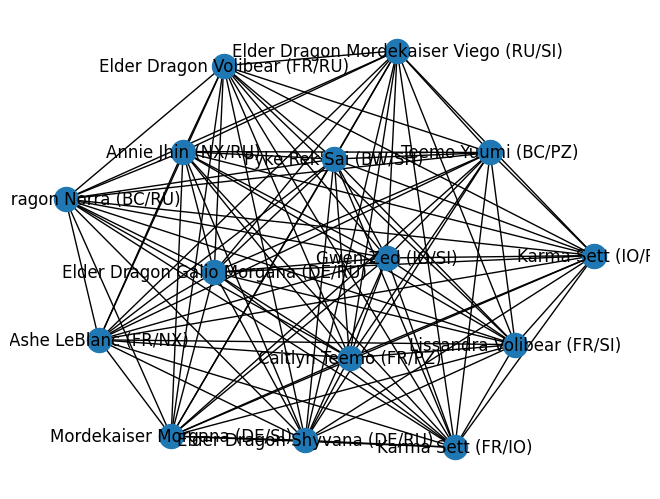

In [93]:
nx.draw(G, with_labels=True)